# Create a time series using a dask CLuster
* connect data to a horizontal slice from SMT simulation data
* examples for ssh, temperature and salinity


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
%%time
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
# import seawater as sw
import datetime

import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots
CPU times: user 2 s, sys: 2.02 s, total: 4.02 s
Wall time: 50.8 s


## Simulation details

In [33]:
run = 'ngSMT_tke'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
month = '03'

In [34]:
## choose month
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'

In [35]:
#### prep. dask cluster
search_str = f'_h_sp_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [96]:
### Temperature
#### prep. dask cluster
search_str = f'_T_S_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [15]:
search_str = f'_vn_sp_001-016_*.nc'
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
flist

array(['/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100301T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100302T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100303T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100304T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100305T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100306T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100307T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100308T010000Z.nc',
       '/mnt/lustre01/wo

optional cluster arguments:

'mfdset_kwargs = dict(combine='nested', concat_dim='flist', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )'

## create a dask Cluster

In [7]:
## Start cluster

!echo $HOSTNAME

mlogin105


In [8]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "320GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [9]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [10]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=320G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/u/u241317/PostProc8uftnstb
#SBATCH --begin=now
#SBATCH --output=/scratch/u/u241317/PostProc8uftnstb/LOG_cluster.%j.o
#SBATCH --output=/scratch/u/u241317/PostProc8uftnstb/LOG_cluster.%j.o

/work/mh0033/u241317/miniconda3/envs/pyicon_py38/bin/python -m distributed.cli.dask_worker tcp://10.50.32.34:43517 --nthreads 4 --nprocs 6 --memory-limit 53.33GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/u/u241317/PostProc8uftnstb --interface ib0 --protocol tcp://



In [11]:
cluster.scale(jobs=2)
cluster

In [14]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34310006       gpu PostProc  u241317  R      20:25      1 mg205
          34310007       gpu PostProc  u241317  R      20:25      1 mg206


In [15]:
client = Client(cluster)
client

<Client: 'tcp://10.50.32.34:43517' processes=12 threads=48, memory=639.96 GiB>

## Load data

In [ ]:
import sys
import numpy as np
from netCDF4 import Dataset, num2date
from ipdb import set_trace as mybreak
import pyicon as pyic
import glob
import pickle
import maps_icon_smt_temp as smt
import datetime
import xarray as xr
import pandas as pd
from icon_smt_levels import dzw, dzt, depthc, depthi

### configure paths
run      = 'ngSMT_tke'
savefig  = False
path_fig = '../pics/'
nnf      = 0

gname = 'smt'
lev   = 'L128'

path_data    = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/????-??/'

#####################################################################
### Calculate dudz over all layers for one timestep
levs   = np.arange(depthc.size)
nz     = levs.size
depthc = depthc[levs]

cc        = int(59799625)
nzi       = int(nz+1)

fpatho = '/work/mh0033/u241317/smt/vh/pp_calc_v_h.nc'
fo = Dataset(fpatho, 'w', format='NETCDF4')
fo.createDimension('depthc', nz) 
fo.createDimension('cc', cc) # new dim cell center

nc_u   = fo.createVariable('u','f4',('depthc','cc'))
nc_v   = fo.createVariable('v','f4',('depthc','cc'))
ncv    = fo.createVariable('depthc','f4','depthc')
ncv[:] = depthc[:nz]

# --- prepare output netcdf file
ts      = pyic.timing(ts, 'prepare nc')
varfile = 'vn'
layers  = (  ['sp_001-016']*16 + ['sp_017-032']*16 + ['sp_033-048']*16
          + ['sp_049-064']*16 + ['sp_065-080']*16 + ['sp_081-096']*16 + ['sp_097-112']*16)

# --- load times and flist # only to get time data - it is not the selection of data
time0      = np.datetime64('2010-03-09T01:00:00')
ts         = pyic.timing(ts, 'load times and flist')
search_str = f'{run}_vn_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')

itd     = np.argmin((timesd-time0).astype(float)**2)
fpath   = flist_tsd[itd]
pdtime0 = pd.to_datetime(time0) 
tstr    = pdtime0.strftime('%Y%m%d')+'T010000Z'

#calc coeff
grid_sphere_radius = 6.371229e6

fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
vlon = f.variables['vlon'][:] * 180./np.pi # vertex longitude
vlat = f.variables['vlat'][:] * 180./np.pi # vertex latitude
vertex_of_cell = f.variables['vertex_of_cell'][:].transpose()-1 # vertices of each cellcells ad
edge_of_cell = f.variables['edge_of_cell'][:].transpose()-1 # edges of each cellvertices
edges_of_vertex = f.variables['edges_of_vertex'][:].transpose()-1 # edges around vertex
dual_edge_length = f.variables['dual_edge_length'][:] # lengths of dual edges (distances between triangul 
edge_orientation = f.variables['edge_orientation'][:].transpose()
edge_length = f.variables['edge_length'][:] # lengths of edges of triangular cells
cell_area_p = f.variables['cell_area_p'][:] # area of grid cell 
dual_area = f.variables['dual_area'][:] # areas of dual hexagonal/pentagonal cells
#edge_length = f.variables['edge_length'][:]
adjacent_cell_of_edge = f.variables['adjacent_cell_of_edge'][:].transpose()-1 # cells adjacent to each edge 
orientation_of_normal = f.variables['orientation_of_normal'][:].transpose() # orientations of normals to triangular cell edges
edge_vertices = f.variables['edge_vertices'][:].transpose()-1 #vertices at the end of of each edge
f.close()

dtype = 'float32'
f = Dataset(fpath_tgrid, 'r')
elon = f.variables['elon'][:] * 180./np.pi #edge midpoint longitude
elat = f.variables['elat'][:] * 180./np.pi #edge midpoint latitude
cell_cart_vec = np.ma.zeros((clon.size,3), dtype=dtype)
cell_cart_vec[:,0] = f.variables['cell_circumcenter_cartesian_x'][:] # cartesian position of the prime cell circumcenter
cell_cart_vec[:,1] = f.variables['cell_circumcenter_cartesian_y'][:]
cell_cart_vec[:,2] = f.variables['cell_circumcenter_cartesian_z'][:]
edge_cart_vec = np.ma.zeros((elon.size,3), dtype=dtype)
edge_cart_vec[:,0] = f.variables['edge_middle_cartesian_x'][:] # prime edge center cartesian coordinate x on unit
edge_cart_vec[:,1] = f.variables['edge_middle_cartesian_y'][:]
edge_cart_vec[:,2] = f.variables['edge_middle_cartesian_z'][:]
f.close()

dist_vector        = edge_cart_vec[edge_of_cell,:] - cell_cart_vec[:,np.newaxis,:]
norm               = np.sqrt(pyic.scalar_product(dist_vector,dist_vector,dim=2))
prime_edge_length  = edge_length/grid_sphere_radius
fixed_vol_norm     = (0.5 * norm * (prime_edge_length[edge_of_cell]))
fixed_vol_norm     = fixed_vol_norm.sum(axis=1)
edge2cell_coeff_cc = (dist_vector * (edge_length[edge_of_cell,np.newaxis] / grid_sphere_radius) * orientation_of_normal[:,:,np.newaxis] )

sinLon = np.sin(clon*np.pi/180.)
cosLon = np.cos(clon*np.pi/180.)
sinLat = np.sin(clat*np.pi/180.)
cosLat = np.cos(clat*np.pi/180.)

#only march
path_data = '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/'

#now = datetime.now().time() # time object
print('start calculate at')

####  
for kk, lev in enumerate(levs):
  print('lev', lev)
  #ts = pyic.timing(ts, 'loop step')
  # --- load horizontal velocity 1
  fname = f'{run}_{varfile}_{layers[lev]}_{tstr}.nc'
  fpath = f'{path_data}{fname}'
  var   = f'vn{lev+1:03d}_sp'
  #print(f'kk = {kk}/{nz}; fname = {fname}; var = {var}')
  fi   = Dataset(fpath, 'r')
  ve   = fi.variables[var][itsd[itd],:]
  fi.close()

  p_vn_c = ( edge2cell_coeff_cc[:,:,:]
           * ve[edge_of_cell,np.newaxis]
           * dzw[lev]
           ).sum(axis=1)
  p_vn_c *= 1./(fixed_vol_norm[:,np.newaxis]*dzw[lev])

  u1 = p_vn_c[:,0]
  u2 = p_vn_c[:,1]
  u3 = p_vn_c[:,2]

  uo =   u2*cosLon - u1*sinLon
  vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat
    
  #save
  nc_u[kk,:] = uo[:cc]
  nc_v[kk,:] = vo[:cc]


fo.close()

#now = datetime.now().time() # time object
print('finish calculate at')

In [68]:
# --- load times and flist # only to get time data - it is not the selection of data
path_data    = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/????-??/'
time0      = np.datetime64('2010-03-09T01:00:00')
search_str = f'{run}_vn_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
timesd, flist_tsd, itsd = pyic.get_timesteps(flist, time_mode='float2date')

itd     = np.argmin((timesd-time0).astype(float)**2)
fpath   = flist_tsd[itd]
pdtime0 = pd.to_datetime(time0) 
tstr    = pdtime0.strftime('%Y%m%d')+'T010000Z'

#calc coeff

In [73]:
#fname = f'{run}_{varfile}_{layers[lev]}_{tstr}.nc'
#fpath = f'{path_data}{fname}'
#var   = f'vn{lev+1:03d}_sp'
#print(f'kk = {kk}/{nz}; fname = {fname}; var = {var}')
fi   = Dataset('/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/ngSMT_tke_vn_sp_001-016_20100301T010000Z.nc', 'r')
ve = fi.variables['vn001_sp'][0,:]
fi.close()

In [74]:
ve.shape

(89813639,)

In [16]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [140]:
flist

array([], dtype=float64)

In [36]:
%%time
dh = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs
dh = dh.assign_coords({"clon": ("ncells", clon)})
dh = dh.assign_coords({"clat": ("ncells", clat)})
h = dh.h_sp

#h = dh.S001_sp
#h = dh.vn001_sp
#h = dh.T001_sp.T
h

CPU times: user 263 ms, sys: 21 ms, total: 284 ms
Wall time: 500 ms


<xarray.DataArray 'h_sp' (time: 372, ncells: 59799625)>
dask.array<concatenate, shape=(372, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -54.21 -54.22 -54.22 ... -71.82 -71.8 -71.82
    clat     (ncells) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: ncells
Attributes:
    standard_name:                height sp
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

## calculate coefficients to calculate horizontal velocity

In [24]:
grid_sphere_radius = 6.371229e6

fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
vlon = f.variables['vlon'][:] * 180./np.pi # vertex longitude
vlat = f.variables['vlat'][:] * 180./np.pi # vertex latitude
vertex_of_cell = f.variables['vertex_of_cell'][:].transpose()-1 # vertices of each cellcells ad
edge_of_cell = f.variables['edge_of_cell'][:].transpose()-1 # edges of each cellvertices
edges_of_vertex = f.variables['edges_of_vertex'][:].transpose()-1 # edges around vertex
dual_edge_length = f.variables['dual_edge_length'][:] # lengths of dual edges (distances between triangul 
edge_orientation = f.variables['edge_orientation'][:].transpose()
edge_length = f.variables['edge_length'][:] # lengths of edges of triangular cells
cell_area_p = f.variables['cell_area_p'][:] # area of grid cell 
dual_area = f.variables['dual_area'][:] # areas of dual hexagonal/pentagonal cells
#edge_length = f.variables['edge_length'][:]
adjacent_cell_of_edge = f.variables['adjacent_cell_of_edge'][:].transpose()-1 # cells adjacent to each edge 
orientation_of_normal = f.variables['orientation_of_normal'][:].transpose() # orientations of normals to triangular cell edges
edge_vertices = f.variables['edge_vertices'][:].transpose()-1 #vertices at the end of of each edge
f.close()

dtype = 'float32'
f = Dataset(fpath_tgrid, 'r')
elon = f.variables['elon'][:] * 180./np.pi #edge midpoint longitude
elat = f.variables['elat'][:] * 180./np.pi #edge midpoint latitude
cell_cart_vec = np.ma.zeros((clon.size,3), dtype=dtype)
cell_cart_vec[:,0] = f.variables['cell_circumcenter_cartesian_x'][:] # cartesian position of the prime cell circumcenter
cell_cart_vec[:,1] = f.variables['cell_circumcenter_cartesian_y'][:]
cell_cart_vec[:,2] = f.variables['cell_circumcenter_cartesian_z'][:]
edge_cart_vec = np.ma.zeros((elon.size,3), dtype=dtype)
edge_cart_vec[:,0] = f.variables['edge_middle_cartesian_x'][:] # prime edge center cartesian coordinate x on unit
edge_cart_vec[:,1] = f.variables['edge_middle_cartesian_y'][:]
edge_cart_vec[:,2] = f.variables['edge_middle_cartesian_z'][:]
f.close()

dist_vector        = edge_cart_vec[edge_of_cell,:] - cell_cart_vec[:,np.newaxis,:]
norm               = np.sqrt(pyic.scalar_product(dist_vector,dist_vector,dim=2))
prime_edge_length  = edge_length/grid_sphere_radius
fixed_vol_norm     = (0.5 * norm * (prime_edge_length[edge_of_cell]))
fixed_vol_norm     = fixed_vol_norm.sum(axis=1)
edge2cell_coeff_cc = (dist_vector * (edge_length[edge_of_cell,np.newaxis] / grid_sphere_radius) * orientation_of_normal[:,:,np.newaxis] )

sinLon = np.sin(clon*np.pi/180.)
cosLon = np.cos(clon*np.pi/180.)
sinLat = np.sin(clat*np.pi/180.)
cosLat = np.cos(clat*np.pi/180.)

from icon_smt_levels import dzw, dzt, depthc, depthi

In [80]:
h1 = h.transpose()
h1

<xarray.DataArray 'vn001_sp' (ncells: 89813639, time: 372)>
dask.array<transpose, shape=(89813639, 372), dtype=float32, chunksize=(89813639, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                vn at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  3

In [97]:
#ve     = xr.DataArray(ve[np.newaxis,:], dims=['depth', 'edge'])
ve

<xarray.DataArray (depth: 1, edge: 89813639)>
array([[ 0.04487361, -0.3007509 ,  0.24034214, ...,  0.05802205,
        -0.11952303,  0.04791313]], dtype=float32)
Dimensions without coordinates: depth, edge

In [120]:
!squeue | grep u241317

          34305994       gpu PostProc  u241317  R    3:47:22      1 mg205
          34305993       gpu PostProc  u241317  R    5:02:27      1 mg206


In [124]:
a = ds_IcD.cell_area.compute()

In [128]:
ds_IcD.nbytes/1024.**3

22.75425936281681

In [129]:
%%time
ds_tg = xr.open_mfdataset(fpath_tgrid)
ds_IcD = pyic.convert_tgrid_data(ds_tg)
ds_IcD = ds_IcD.persist()

CPU times: user 305 ms, sys: 10 ms, total: 315 ms
Wall time: 306 ms


/work/mh0033/u241317/pyicon/pyicon/pyicon_calc_xr.py:108: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ds_IcD['fc'] = 2.* ds_IcD.earth_angular_velocity * xr.ufuncs.sin(ds_IcD.clat*np.pi/180.)
/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/work/mh0033/u241317/pyicon/pyicon/pyicon_calc_xr.py:109: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ds_IcD['fe'] = 2.* ds_IcD.earth_angular_velocity * xr.ufuncs.sin(ds_IcD.elat*np.pi/180.)
/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/work/mh0033/u241317/pyicon/pyic

In [118]:
ds_IcD

<xarray.Dataset>
Dimensions:                 (cell: 59799625, vertex: 30008985, edge: 89813639, nc: 2, nv: 3, ne: 6, cart: 3)
Coordinates:
    clon                    (cell) float64 dask.array<chunksize=(59799625,), meta=np.ndarray>
    clat                    (cell) float64 dask.array<chunksize=(59799625,), meta=np.ndarray>
    vlon                    (vertex) float64 dask.array<chunksize=(30008985,), meta=np.ndarray>
    vlat                    (vertex) float64 dask.array<chunksize=(30008985,), meta=np.ndarray>
    elon                    (edge) float64 dask.array<chunksize=(89813639,), meta=np.ndarray>
    elat                    (edge) float64 dask.array<chunksize=(89813639,), meta=np.ndarray>
Dimensions without coordinates: cell, vertex, edge, nc, nv, ne, cart
Data variables: (12/39)
    grid_sphere_radius      float64 6.371e+06
    grav                    float64 9.807
    earth_angular_velocity  float64 7.292e-05
    rho0                    float64 1.025e+03
    rhoi                    float64 917.0
    rhos                    float64 300.0
    ...                      ...
    edge_cart_vec           (edge, cart) float64 dask.array<chunksize=(89813639, 1), meta=np.ndarray>
    dual_edge_cart_vec      (edge, cart) float64 dask.array<chunksize=(89813639, 1), meta=np.ndarray>
    edge_prim_norm          (edge, cart) float64 dask.array<chunksize=(89813639, 1), meta=np.ndarray>
    fc                      (cell) float64 dask.array<chunksize=(59799625,), meta=np.ndarray>
    fe                      (edge) float64 dask.array<chunksize=(89813639,), meta=np.ndarray>
    fv                      (vertex) float64 dask.array<chunksize=(30008985,), meta=np.ndarray>

In [135]:
########### compute coefficients #############
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'

#ds_tg = xr.open_dataset(fpath_tgrid, chunks=dict())
ds_tg = xr.open_mfdataset(fpath_tgrid)
ds_IcD = pyic.convert_tgrid_data(ds_tg)
ds_IcD = ds_IcD.persist()
fixed_vol_norm = pyic.xr_calc_fixed_volume_norm(ds_IcD.persist())

div_coeff = pyic.xr_calc_div_coeff(ds_IcD)
div_coeff = div_coeff.compute()

edge2cell_coeff_cc = pyic.xr_calc_edge2cell_coeff_cc(ds_IcD)
edge2cell_coeff_cc = edge2cell_coeff_cc.compute()

edge2cell_coeff_cc_t = pyic.xr_calc_edge2cell_coeff_cc_t(ds_IcD).compute()

/work/mh0033/u241317/pyicon/pyicon/pyicon_calc_xr.py:108: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ds_IcD['fc'] = 2.* ds_IcD.earth_angular_velocity * xr.ufuncs.sin(ds_IcD.clat*np.pi/180.)
/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/work/mh0033/u241317/pyicon/pyicon/pyicon_calc_xr.py:109: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ds_IcD['fe'] = 2.* ds_IcD.earth_angular_velocity * xr.ufuncs.sin(ds_IcD.elat*np.pi/180.)
/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/work/mh0033/u241317/pyicon/pyic

TypeError: unexpected indexer type for VectorizedIndexer: dask.array<sub, shape=(59799625, 3), dtype=int32, chunksize=(59799625, 3), chunktype=numpy.ndarray>

In [85]:
lev=0
#interpolated to cell center and back
#ve     = xr.DataArray(ve[np.newaxis,:], dims=['depth', 'edge'])


dze    = xr.DataArray(dzw[lev]*np.ones((1,h.size)), dims=['depth', 'edge'])
p_vn_c = pyic.xr_edges2cell(ds_IcD, h, dze, dzw[lev], edge2cell_coeff_cc=edge2cell_coeff_cc, fixed_vol_norm=fixed_vol_norm)
#p_vn_c = p_vn_c.where(wet_c.isel(depthc=lev)!=0.)
#vei    = pyic.xr_cell2edges(ds_IcD, p_vn_c, edge2cell_coeff_cc_t=edge2cell_coeff_cc_t)
#vei    = vei.where(wet_e.isel(depthc=lev)!=0.)*dzw[lev]
      
#div_h  = pyic.xr_calc_div(ds_IcD, vei, div_coeff)

u1 = p_vn_c[:,0]
u2 = p_vn_c[:,1]
u3 = p_vn_c[:,2]

uo =   u2*cosLon - u1*sinLon
vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat



IndexError: Unlabeled multi-dimensional array cannot be used for indexing: ncells

In [ ]:
ds = xr.Dataset(
     data_vars=dict(
         u=(["ncells", "time"], uo),
         v=(["ncells", "time"], vo),
     ),
     coords=dict(
         clon=(["ncells"], clon),
         clat=(["ncells"], clat),
     ),
)

<xarray.DataArray 'vn001_sp' (time: 372, ncells: 89813639)>
dask.array<concatenate, shape=(372, 89813639), dtype=float32, chunksize=(1, 89813639), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                vn at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  3

### select region

#### select a horizontal slice

In [25]:
lon = [-75, -10]
lat = [39, 39.01]
h0 = h.where((h.clat > lat[0]) & (h.clat < lat[1]) & (h.clon > lon[0]) & (h.clon < lon[1]), drop=True)
h0

<xarray.DataArray 'h_sp' (time: 276, ncells: 11882)>
dask.array<where, shape=(276, 11882), dtype=float32, chunksize=(1, 11882), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -52.93 -52.93 -52.94 ... -10.11 -10.03 -10.14
    clat     (ncells) float64 39.0 39.01 39.0 39.0 ... 39.01 39.01 39.0 39.0
Dimensions without coordinates: ncells
Attributes:
    standard_name:                height sp
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [26]:
#ind_reg = np.argmin( (clon-lon[0])**2 + (clon-lon[1])**2 + (clat-lat[0])**2 + (clat-lat[1])**2  )  
#ind_reg = np.argmin( (clon-lon[0])**2 & (clon-lat[0])**2 )  
#ic = np.argmin( (clon-lon[0])**2 + (clat-lat[0])**2 ) 

#### selct a line section
1. Option

In [18]:
lon = [-62, -62]
lat = [20, 70]

In [19]:
def ckdtree_section(p1, p2, npoints=101, 
                fname_tgrid='',
                path_tgrid='',
                path_ckdtree='',
                sname='auto',
                gname='',
                tgname='',
                n_nearest_neighbours=1,
                n_jobs=1,
                load_cgrid=True,
                load_egrid=True,
                load_vgrid=True,
                save_as_nc=True,
                ):
    
 """
 """
 if tgname=='':
    Drgrid = identify_grid(path_tgrid, path_tgrid+fname_tgrid) 
    tgname = Drgrid['name']
 lon1str, lat1str = pyic.lonlat2str(p1[0], p1[1])
 lon2str, lat2str = pyic.lonlat2str(p2[0], p2[1])
 if sname=='auto':
   sname = fpath_ckdtree.split('/')[-1][:-4]
 if save_as_nc:
   ending='nc'
 else:
   ending='npz'
 #fname = '%s_nps%d_%s%s_%s%s.npz'%(tgname, npoints, lon1str, lat1str, lon2str, lat2str) 
 fname = f'{tgname}_nps{npoints:d}_{lon1str}{lat1str}_{lon2str}{lat2str}.{ending}'
 fpath_ckdtree = path_ckdtree+fname
 fpath_tgrid   = path_tgrid+fname_tgrid
 # --- derive section points
 lon_sec, lat_sec, dist_sec = pyic.derive_section_points(p1, p2, npoints)
 lon_o = lon_sec
 lat_o = lat_sec
 # --- calculate ckdtree
 Dind_dist = pyic.ckdtree_points(fpath_tgrid, lon_o, lat_o, load_cgrid=load_cgrid, load_egrid=load_egrid, load_vgrid=load_vgrid, n_nearest_neighbours=n_nearest_neighbours,
                            n_jobs=n_jobs)
 # --- save grid
 print('Saving grid file: %s' % (fpath_ckdtree))
 if save_as_nc:
   ds = xr.Dataset()
   ds['lon_sec'] = xr.DataArray(lon_sec, dims=['isec'])
   ds['lat_sec'] = xr.DataArray(lat_sec, dims=['isec'])
   ds['dist_sec'] = xr.DataArray(dist_sec, dims=['isec'])
   for var in Dind_dist.keys(): 
     ds[var] = xr.DataArray(Dind_dist[var], dims=['isec'])
   ds.to_netcdf(fpath_to_indices)
 else:
   np.savez(fpath_ckdtree,
             lon_sec=lon_sec,
             lat_sec=lat_sec,
             dist_sec=dist_sec,
             sname=sname,
             gname=gname,
             **Dind_dist
            )
 return Dind_dist['dckdtree_c'], Dind_dist['ickdtree_c'], lon_sec, lat_sec, dist_sec

In [20]:
# carfully choose npoints to have only unique values
# pyicon function has to be adapted, select save directory
sname = '75_10W_39N'
path_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
tgname        = 'smt'
gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
fname_tgrid   = f'{gname}.nc'
path_ckdtree  = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{tgname}/ckdtree/'
path_rgrid    = path_ckdtree + 'rectgrids/'
path_sections = path_ckdtree + 'sections/'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_to_indices = path_scratch + 'indices.nc'


dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = ckdtree_section(p1=[lon[0],lat[1]], p2=[lon[0],lat[0]], npoints=4000,
                      fname_tgrid  = fname_tgrid,
                      path_tgrid   = path_tgrid,
                      path_ckdtree = path_sections,
                      sname = sname,
                      gname = gname,
                      tgname = tgname,
                      load_egrid=False,
                      load_vgrid=False,
                      )

Saving grid file: /mnt/lustre01/work/mh0033/m300602/icon/grids/smt/ckdtree/sections/smt_nps4000_62W70N_62W20N.nc


In [37]:
h1 = dh.isel(ncells=ickdtree)
h1 = h1.assign_coords({"rlon": ("ncells", lon_sec)}) #keep old lat and lon TODO overwrite
h1 = h1.assign_coords({"rlat": ("ncells", lat_sec)})
h1

<xarray.Dataset>
Dimensions:  (time: 372, ncells: 4000)
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -62.0 -62.0 -62.0 -62.02 ... -62.0 -62.0 -62.0
    clat     (ncells) float64 70.01 69.98 69.97 69.97 ... 20.04 20.03 20.01 20.0
    rlon     (ncells) float64 -62.0 -62.0 -62.0 -62.0 ... -62.0 -62.0 -62.0
    rlat     (ncells) float64 70.0 69.99 69.97 69.96 ... 20.04 20.03 20.01 20.0
Dimensions without coordinates: ncells
Data variables:
    h_sp     (time, ncells) float32 dask.array<chunksize=(1, 4000), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20054 (Linux 2.6....

Visualisation of nearest neighbour method:

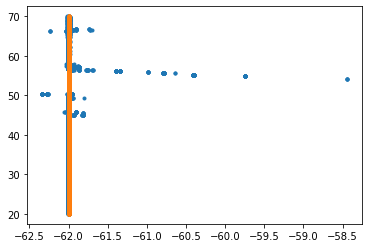

In [26]:

plt.scatter(h1.clon, h1.clat, marker=".")
plt.scatter(h1.rlon, lat_sec, marker=".")

### compute and save data

In [38]:
#fpath = f'{path_scratch}/time_series_analysis_ssh_2d_1.nc'
fpath = f'{path_scratch}/time_series_ssh_line_lat_{month}.nc'
print(f'Saving file {fpath}')
h1.to_netcdf(fpath)

Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//time_series_ssh_line_lat_03.nc


repeat this process for the three simulated month of the SMT datasets - dont forget to change filenames ;)

### combine data of 3 month using time

In [39]:
#### prep. dask cluster
path_data = path_scratch
#search_str = f'time_series_analysis_ssh_2d_*.nc' 
search_str = f'time_series_ssh_line_lat*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
flist

array(['/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_lat_01.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_lat_02.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_ssh_line_lat_03.nc'],
      dtype='<U68')

In [40]:
dH = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs

### save final dataset

In [41]:
#fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_ssh_2d.nc'
fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_ssh_line_lat.nc'
print(f'Saving file {fpath}')
dH.to_netcdf(fpath)

Saving file /work/mh0033/u241317/smt/time_series_analysis/time_series_ssh_line_lat.nc


#### a first glance on the new dataset

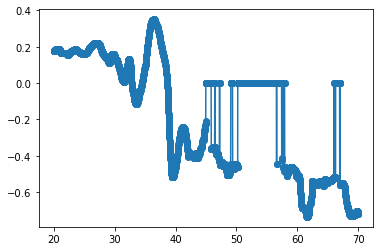

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

tt = dH.isel(ncells=500)
#fig, ax = plt
plt.plot( dH.rlat, dH.h_sp.isel(time=1), marker="o")
#plt.show()

#### close cluster properly

In [44]:
client.close()
cluster.close()